# Data Overview from opendata.dk

The available parking spaces and their occupancy are counted in Copenhagen and the data sets are available on [Opendata](opendata.dk). There are two datasets available: 
- **Parking spaces**: The data set shows legal parking spaces during the day (7am-6pm) at street level (on public and private shared roads), parking spaces in publicly owned parking facilities as well as parking spaces without a parking system. Parking options for electric cars, shared cars, taxis and disabled drivers appear. Also includes parking spaces reserved for embassies and consulates.
- **Parking counts**: Parking counts on roads/road sections are conducted twice in March and October at 12:00, 17:00 and 22:00 in selected areas. Parking occupancy rates are calculated based on the parking counts.

The data sets will be analyzed and preprocessed in the following cells.

!NB the fields lovlig_p indicate the number of parking spaces. It does not indicate the number of legal parking spaces.
The fields occupancy_ indicate parked_cars divided by legal_p * 100 (rounded)

In [176]:
## Imports
import matplotlib.pyplot as plt
import pandas as pd
import os
from shapely import wkt
import geopandas as gpd
import numpy as np

## Parking counts

In [177]:
data_path = os.path.abspath(os.path.join(os.pardir, "projectData"))
cleaned_data_path = os.path.join(data_path, "parking_counts.csv")
df_counts = pd.read_csv(cleaned_data_path)

In [178]:
# Drop redundant columns and assign the result back to df
df_counts = df_counts.drop(columns=["FID", "pkey", "taelle_id", "bemaerkning", "kategori", "ogc_fid", "id", "vej_id"])

# Replace NaN with empty string and -1
df_counts["straekning"] = df_counts["straekning"].fillna("")
df_counts["fra_m"] = df_counts["fra_m"].fillna(-1)
df_counts["til_m"] = df_counts["til_m"].fillna(-1)

df_counts.head()

,vejnavn,straekning,lovlig_p_kl_12,parkerede_biler_kl_12,belaegning_kl_12_pct,lovlig_p_kl_17,parkerede_biler_kl_17,belaegning_kl_17_pct,lovlig_p_kl_22,parkerede_biler_kl_22,belaegning_kl_22_pct,aar_mnd,fra_m,til_m,omraade,wkb_geometry
0,Dyrkøb,,41,40.0,98.0,41,32.0,78.0,41,24.0,59.0,201609.0,0.0,115.0,1.0,MULTILINESTRING ((12.573769564824445 55.679320...
1,Dyrkøb,,41,45.0,110.0,41,36.0,88.0,41,35.0,85.0,201303.0,0.0,115.0,1.0,MULTILINESTRING ((12.573769564824445 55.679320...
2,Dyrkøb,,43,46.0,107.0,43,43.0,100.0,43,29.0,67.0,201203.0,0.0,115.0,1.0,MULTILINESTRING ((12.573769564824445 55.679320...
3,Dyrkøb,,41,44.0,107.0,41,44.0,107.0,41,37.0,90.0,201403.0,0.0,115.0,1.0,MULTILINESTRING ((12.573769564824445 55.679320...
4,Dyrkøb,,41,40.0,98.0,41,20.0,49.0,41,18.0,44.0,201603.0,0.0,115.0,1.0,MULTILINESTRING ((12.573769564824445 55.679320...


In [179]:
### Correct date

# Only a single entry has a blank date, so we remove it
df_counts.dropna(subset=["aar_mnd"], inplace=True) #Remove rows with NaN in "aar_mnd" column

## aar_mnd is a float with format YYYYMM, so we need to convert it to a datetime object
df_counts['aar_mnd_dt'] = pd.to_datetime(df_counts['aar_mnd'].astype(int).astype(str), format='%Y%m')
# Seperate year and month into two columns
df_counts['aar'] = df_counts['aar_mnd_dt'].dt.year
df_counts['mnd'] = df_counts['aar_mnd_dt'].dt.month
# Drop the original column
df_counts.drop(columns=["aar_mnd_dt"], inplace=True) #Remove the original column
df_counts.drop(columns=["aar_mnd"], inplace=True) #Remove the original column


In [180]:
### Save to new CSV file
#Rename/translate the columns to English to be more readable

df_counts.rename(columns={"vejnavn": "street_name", 
                   "straekning": "stretch",
                   "lovlig_p_kl_12": "legal_p_at_12",
                   "parkerede_biler_kl_12": "parked_cars_at_12",
                   "belaegning_kl_12_pct": "occupancy_at_12_pct",
                   "lovlig_p_kl_17": "legal_p_at_17",
                   "parkerede_biler_kl_17": "parked_cars_at_17",
                   "belaegning_kl_17_pct": "occupancy_at_17_pct",
                   "lovlig_p_kl_22": "legal_p_at_22",
                   "parkerede_biler_kl_22": "parked_cars_at_22",
                   "belaegning_kl_22_pct": "occupancy_at_22_pct",
                   "aar": "year",
                   "mnd": "month",
                   "vej_id": "street_id",
                   "fra_m": "from_m",
                   "til_m": "to_m",
                   "omraade": "area",
                   }, inplace=True)

for col in df_counts.columns:
    unique_vals = df_counts[col].unique()
    print(f"Column '{col}' has {len(unique_vals)} unique entries:")
    print(unique_vals)
    print("-" * 40)


Column 'street_name' has 1498 unique entries:
['Dyrkøb' 'Gråbrødretorv' 'H.C. Andersens Boulevard' ...
 'Natalie Zahles Vej' 'Vanløsehøj' 'Jacob Erlandsens Gade']
----------------------------------------
Column 'stretch' has 829 unique entries:
['' 'Nørre Voldgade - Bag Rådhuset (kun østlig side, ulige husnr.-side)'
 'Vestergade - Frederiksberggade' 'Nørre Voldgade - Landemærket'
 'TÆLLES IKKE' 'Niels Hemmingsens Gade - Lille Kannikestræde'
 'Lille Kannikestræde - Nørregade' 'H.C. Andersens Boulevard - Nørregade'
 'Jarmers Plads - Vestergade / Rådhuspladsen'
 'Landemærket - Kongens Nytorv' 'Nørre Farimagsgade - Nørre Voldgade'
 "Hovedvagtsgade - Chr. IX's Gade" 'Skanderborggade - Silkeborggade'
 'Gothersgade - Rosenborg' 'Strøget - Holmens Kanal'
 'Asylgade - Admiralgade' 'Stormgade - Ny Vestergade'
 'Bag Rådhuset - Ny Kongensgade (kun østlig side, ulige husnr.-side)'
 'Frederiksberggade - Hestemøllestræde' 'Nordsiden'
 'Sydsiden (Vingårdsstræde)' 'Farvergade - Dantes Plads / Ny Vester

In [181]:
#Save the cleaned data to a new CSV file
df_counts.to_csv(os.path.join(data_path, "cleaned_parking_counts.csv"), index=False)

df_counts.head()

,street_name,stretch,legal_p_at_12,parked_cars_at_12,occupancy_at_12_pct,legal_p_at_17,parked_cars_at_17,occupancy_at_17_pct,legal_p_at_22,parked_cars_at_22,occupancy_at_22_pct,from_m,to_m,area,wkb_geometry,year,month
0,Dyrkøb,,41,40.0,98.0,41,32.0,78.0,41,24.0,59.0,0.0,115.0,1.0,MULTILINESTRING ((12.573769564824445 55.679320...,2016,9
1,Dyrkøb,,41,45.0,110.0,41,36.0,88.0,41,35.0,85.0,0.0,115.0,1.0,MULTILINESTRING ((12.573769564824445 55.679320...,2013,3
2,Dyrkøb,,43,46.0,107.0,43,43.0,100.0,43,29.0,67.0,0.0,115.0,1.0,MULTILINESTRING ((12.573769564824445 55.679320...,2012,3
3,Dyrkøb,,41,44.0,107.0,41,44.0,107.0,41,37.0,90.0,0.0,115.0,1.0,MULTILINESTRING ((12.573769564824445 55.679320...,2014,3
4,Dyrkøb,,41,40.0,98.0,41,20.0,49.0,41,18.0,44.0,0.0,115.0,1.0,MULTILINESTRING ((12.573769564824445 55.679320...,2016,3


In [182]:


# --- 1. Basic Overview of the Data ---
# Print overall dimensions and memory usage.
print("Dataset Dimensions (rows, columns):", df_counts.shape)
memory_mb = df_counts.memory_usage(deep=True).sum() / (1024 * 1024)
print("Total Memory Usage (MB): {:.2f}".format(memory_mb))

# Display basic info on data types and non-null counts.
print("\nDataFrame Information:")
df_counts.info()

# --- 2. Date/Time Properties ---
# Our header does not include a full date, but we do have a 'year' and a 'month' column.

if "year" in df_counts.columns:
    print("\nYear range:", df_counts["year"].min(), "to", df_counts["year"].max())
if "month" in df_counts.columns:
    print("Unique months in data:", df_counts["month"].unique())

# --- 3. Geographic Data (if available) ---
# If the dataset contains a 'wkb_geometry' column, we can try plotting the locations.
if "wkb_geometry" in df_counts.columns:
    try:
        # Convert the wkb_geometry column (assumed to be WKB strings) to geometry objects.
        df_counts['geometry'] = df_counts['wkb_geometry'].apply(lambda x: wkt.loads(x) if pd.notnull(x) else None)
        gdf = gpd.GeoDataFrame(df_counts, geometry='geometry', crs="EPSG:4326")
        print("\nGeographic Data: {} valid geometries out of {}.".format(gdf['geometry'].notnull().sum(), len(gdf)))

        plt.figure(figsize=(8, 6))
        gdf_spacesplot(markersize=1, alpha=0.5)
        plt.title("Scatter Plot of Geographic Locations")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.tight_layout()
        plt.show()

    except ImportError:
        print("\nGeoPandas and/or Shapely is not installed. Install these to plot geographic data.")
    except Exception as e:
        print("\nAn error occurred while plotting geographic data:", e)
else:
    print("\nNo geographic data found (wkb_geometry column is missing).")


Dataset Dimensions (rows, columns): (37910, 17)
Total Memory Usage (MB): 26.38

DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
Index: 37910 entries, 0 to 37910
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   street_name          37910 non-null  object 
 1   stretch              37910 non-null  object 
 2   legal_p_at_12        37910 non-null  int64  
 3   parked_cars_at_12    37897 non-null  float64
 4   occupancy_at_12_pct  37898 non-null  float64
 5   legal_p_at_17        37910 non-null  int64  
 6   parked_cars_at_17    37897 non-null  float64
 7   occupancy_at_17_pct  37898 non-null  float64
 8   legal_p_at_22        37910 non-null  int64  
 9   parked_cars_at_22    37897 non-null  float64
 10  occupancy_at_22_pct  37899 non-null  float64
 11  from_m               37910 non-null  float64
 12  to_m                 37910 non-null  float64
 13  area                 37907 non-null  f

<Figure size 800x600 with 0 Axes>

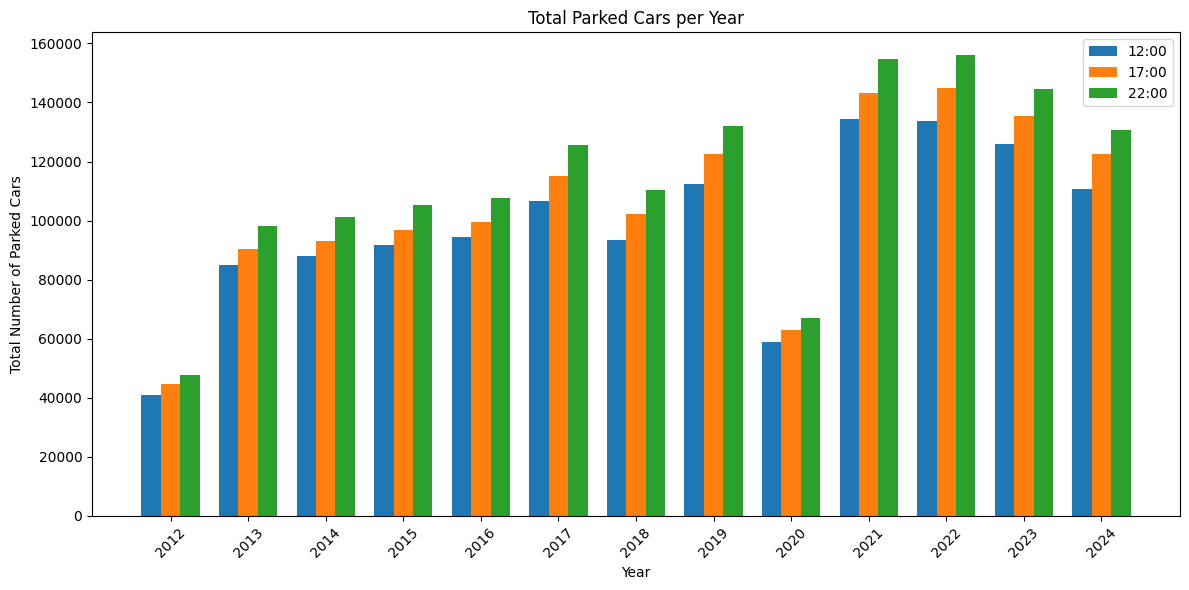

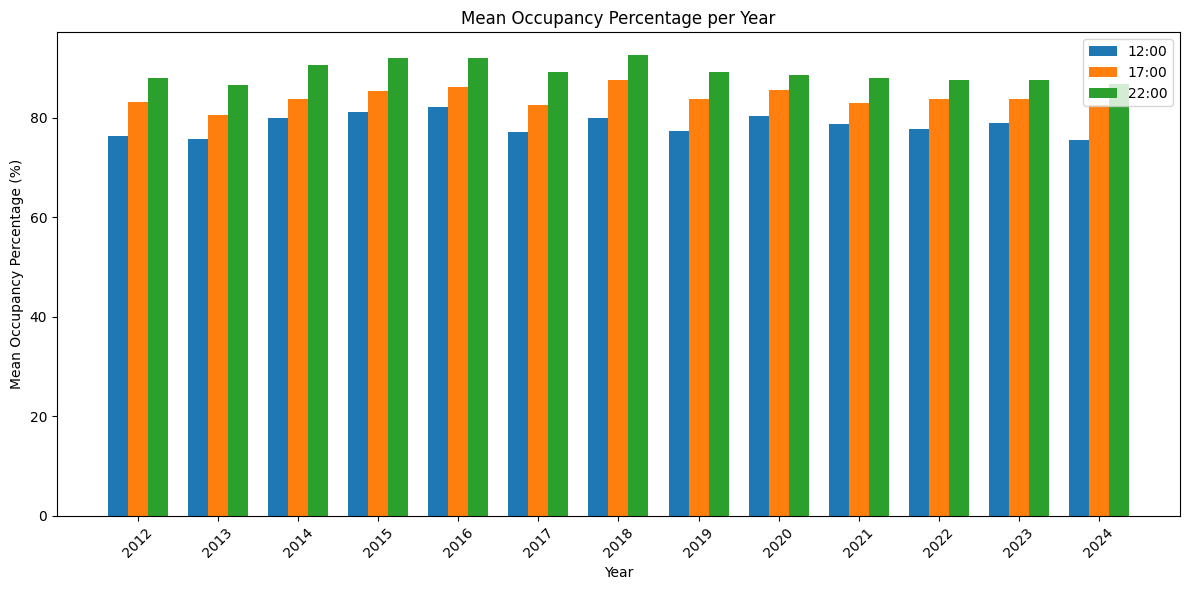

In [183]:
# --- Convert Relevant Columns to Numeric ---
# List of columns for parked cars and occupancy percentages.
parked_cols = ["parked_cars_at_12", "parked_cars_at_17", "parked_cars_at_22"]
occ_cols = ["occupancy_at_12_pct", "occupancy_at_17_pct", "occupancy_at_22_pct"]

# Ensure these columns are numeric (coercing errors if needed)
for col in parked_cols + occ_cols:
    df_counts[col] = pd.to_numeric(df_counts[col], errors='coerce')

# Also ensure the 'year' column is numeric
df_counts['year'] = pd.to_numeric(df_counts['year'], errors='coerce')

# --- Group Data by Year ---
# Rather than grouping over all columns, group only the numeric columns you care about.
grouped_parked = df_counts.groupby("year")[parked_cols].sum()   # Using mean() per year (change to sum() if needed)
grouped_occ = df_counts.groupby("year")[occ_cols].mean()

# Retrieve the sorted years list
years = grouped_parked.index.astype(int).tolist()

# Setup x-axis positions for grouped bar charts
x = np.arange(len(years))
width = 0.25  # width for each individual bar

# --- Plot 1: Mean Parked Cars per Year ---
plt.figure(figsize=(12, 6))
plt.bar(x - width, grouped_parked["parked_cars_at_12"], width=width, label="12:00")
plt.bar(x, grouped_parked["parked_cars_at_17"], width=width, label="17:00")
plt.bar(x + width, grouped_parked["parked_cars_at_22"], width=width, label="22:00")

plt.xlabel("Year")
plt.ylabel("Total Number of Parked Cars")
plt.title("Total Parked Cars per Year")
plt.xticks(x, years, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# --- Plot 2: Mean Occupancy Percentage per Year ---
plt.figure(figsize=(12, 6))
plt.bar(x - width, grouped_occ["occupancy_at_12_pct"], width=width, label="12:00")
plt.bar(x, grouped_occ["occupancy_at_17_pct"], width=width, label="17:00")
plt.bar(x + width, grouped_occ["occupancy_at_22_pct"], width=width, label="22:00")

plt.xlabel("Year")
plt.ylabel("Mean Occupancy Percentage (%)")
plt.title("Mean Occupancy Percentage per Year")
plt.xticks(x, years, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## Parking spaces

In [184]:
# Loading the data set
cleaned_data_path = os.path.join(data_path, "parking_spaces.csv")
df_spaces = pd.read_csv(cleaned_data_path)
df_spaces.columns = df_spaces.columns.str.strip()

# Drop redundant columns and assign the result back to df
df = df_spaces.drop(columns=["FID", "vejside", "bemaerkning", "taelle_id", "startdato_midlertidigt_nedlagt",
                      "slutdato_midlertidigt_nedlagt", "restriktionstype", "restriktionstekst", "taelle_note",
                      "delebilsklub", "aendring_p_ordning", "x", "uuid", "ogc_fid"],  errors='ignore')

# Replace NaN with empty string and -1

# Rename/translate the columns to English to be more readable
df_spaces.rename(columns={
    "vejkode": "street_code", 
    "vejnavn": "street_name", 
    "antal_pladser": "num_spaces", 
    "restriktion": "restriction", 
    "vejstatus": "street_status", 
    "bydel": "district", 
    "p_ordning": "parking_order", 
    "p_type": "parking_type", 
    "p_status": "parking_status", 
    "rettelsedato": "correction_date", 
    "oprettelsesdato": "creation_date", 
    "id": "id", 
    "wkb_geometry": "wkb_geometry"
}, inplace=True)

for col in df_spaces.columns:
    unique_vals = df_spaces[col].unique()
    print(f"Column '{col}' has {len(unique_vals)} unique entries:")
    print(unique_vals)
    print("-" * 40)

Column 'FID' has 28762 unique entries:
['p_pladser.1' 'p_pladser.2' 'p_pladser.3' ... 'p_pladser.28760'
 'p_pladser.28761' 'p_pladser.28762']
----------------------------------------
Column 'street_code' has 2008 unique entries:
[   4    8   72 ... 8847 8848 9802]
----------------------------------------
Column 'street_name' has 2008 unique entries:
['Abel Cathrines Gade' 'Abildgaardsgade' 'Ahrenkildes Allé' ...
 'Burgundyvej' 'Paradisæblevej' 'Frederikssundsvejtunnelen']
----------------------------------------
Column 'num_spaces' has 71 unique entries:
[ 10.   4.   1.   2.   3.  11.  13.   8.   5.   7.   6.  29.  20.  16.
   9.  12.  14.  31.  26.  51.  30.  15.  32.  33.  nan  18.  17.  23.
  24.  35.  47.  19.  28.  25. 191.  21.  38.   0.  22.  27.  37.  36.
  54.  49.  52.  34.  82.  83.  46.  44.  40.  61.  41.  66.  39. 407.
  42.  69. 164.  62.  45.  73.  56.  58.  57.  55.  67. 266.  50. 155.
  53.]
----------------------------------------
Column 'restriction' has 3 unique en

In [185]:
# Save the cleaned data to a new CSV file
df_spaces.to_csv(os.path.join(data_path, "cleaned_parking_spaces.csv"), index=False)

df_spaces.head()

,FID,street_code,street_name,num_spaces,restriction,street_status,vejside,district,parking_order,parking_type,...,startdato_midlertidigt_nedlagt,slutdato_midlertidigt_nedlagt,restriktionstype,restriktionstekst,taelle_note,delebilsklub,aendring_p_ordning,uuid,ogc_fid,wkb_geometry
0,p_pladser.1,4,Abel Cathrines Gade,10.0,nej,Offentlig vej,Lige husnr.,Vesterbro-Kongens Enghave,Grøn betalingszone,Uafmærket parkering,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f091dc0c-e4c1-49d1-8c0e-f2abe9cf3274,1,MULTILINESTRING ((12.558951218164538 55.671519...
1,p_pladser.2,4,Abel Cathrines Gade,4.0,nej,Offentlig vej,Ulige husnr.,Vesterbro-Kongens Enghave,Grøn betalingszone,Uafmærket parkering,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f78e2d50-6d05-4efe-82da-ac3306e91544,2,MULTILINESTRING ((12.559540823191533 55.671430...
2,p_pladser.3,4,Abel Cathrines Gade,4.0,nej,Offentlig vej,Ulige husnr.,Vesterbro-Kongens Enghave,Grøn betalingszone,Uafmærket parkering,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6f1dcd37-a01d-4c43-af33-1ca17476e116,3,MULTILINESTRING ((12.558251725661727 55.671793...
3,p_pladser.4,4,Abel Cathrines Gade,1.0,nej,Offentlig vej,Ulige husnr.,Vesterbro-Kongens Enghave,Grøn betalingszone,Uafmærket parkering,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9a26e4f5-758f-48ab-ad0d-e0549ecad115,4,MULTILINESTRING ((12.55787572262436 55.6718996...
4,p_pladser.5,4,Abel Cathrines Gade,2.0,nej,Offentlig vej,Ulige husnr.,Vesterbro-Kongens Enghave,Grøn betalingszone,Uafmærket parkering,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,aa712abe-4293-4c75-b991-af4f3f5c74c6,5,MULTILINESTRING ((12.55863434613667 55.6716855...


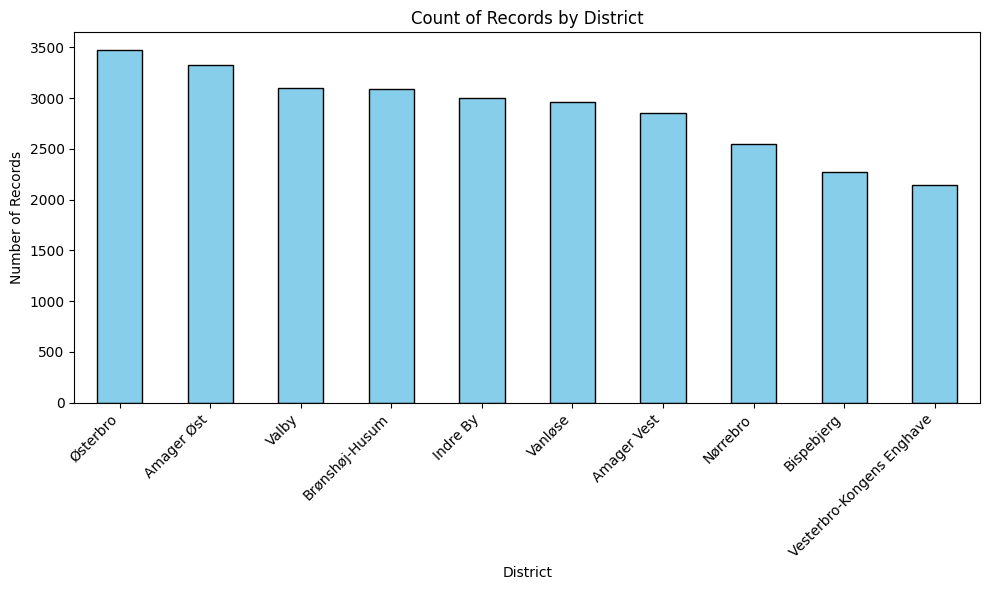

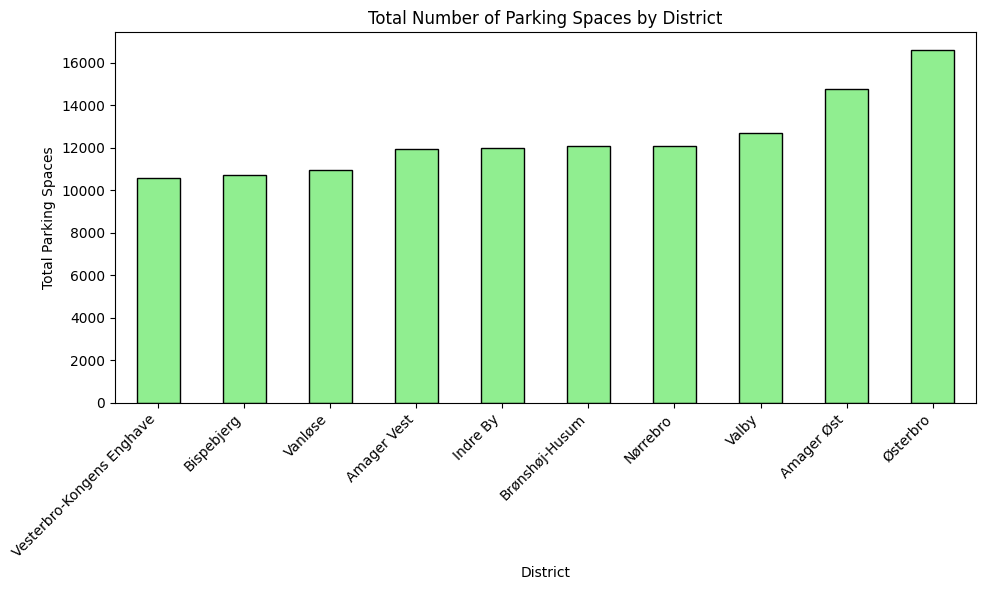

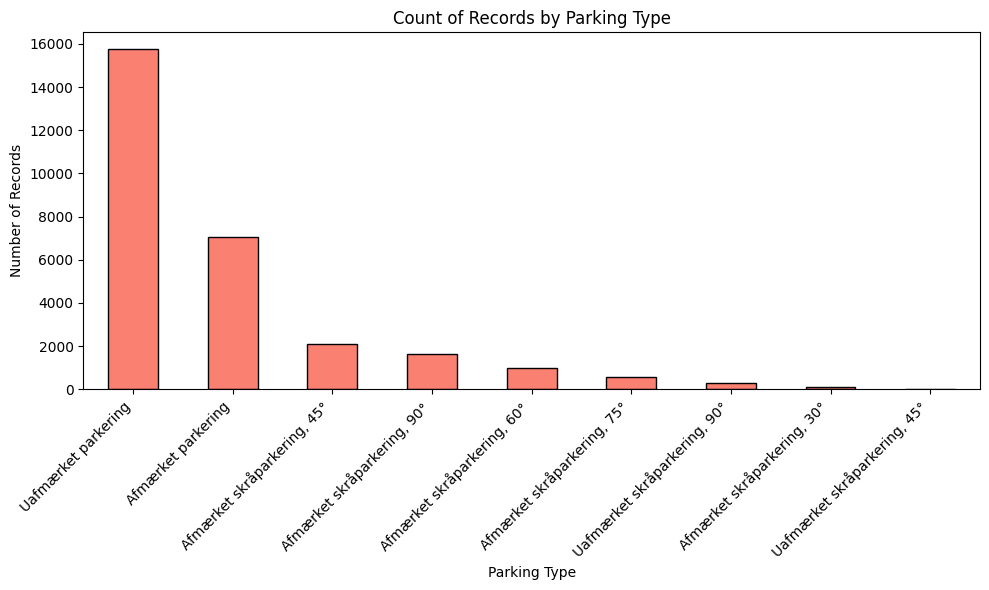

In [186]:
# Ensure the 'num_spaces' column is numeric; convert if needed:
df_spaces['num_spaces'] = pd.to_numeric(df_spaces['num_spaces'], errors='coerce')

# ---------------------------
# Graph 1: Count of Records by District
# ---------------------------
district_counts = df_spaces['district'].value_counts()

plt.figure(figsize=(10, 6))
district_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Count of Records by District")
plt.xlabel("District")
plt.ylabel("Number of Records")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# ---------------------------
# Graph 2: Total Number of Parking Spaces by District
# ---------------------------
spaces_by_district = df_spaces.groupby('district')['num_spaces'].sum()
# Sorting the values (optional) to see the lower-to-higher sum distribution.
spaces_by_district = spaces_by_district.sort_values()

plt.figure(figsize=(10, 6))
spaces_by_district.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title("Total Number of Parking Spaces by District")
plt.xlabel("District")
plt.ylabel("Total Parking Spaces")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# ---------------------------
# Graph 3: Count of Records by Parking Type
# ---------------------------
# (Assuming the column is named 'parking_type'; adjust if it is different.)
parking_type_counts = df_spaces['parking_type'].value_counts()

plt.figure(figsize=(10, 6))
parking_type_counts.plot(kind='bar', color='salmon', edgecolor='black')
plt.title("Count of Records by Parking Type")
plt.xlabel("Parking Type")
plt.ylabel("Number of Records")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


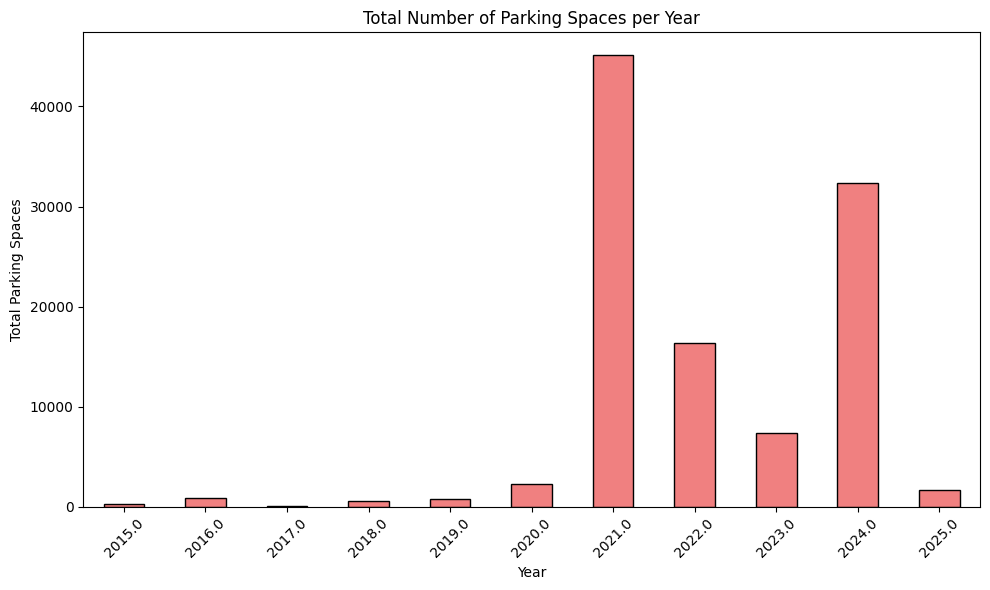

In [187]:
# Convert 'creation_date' to datetime and extract the year.
df_spaces['correction_date'] = pd.to_datetime(df_spaces['correction_date'], errors='coerce')
df_spaces['correction_year'] = df_spaces['correction_date'].dt.year

# Group by the creation year and sum the total number of parking spaces.
spaces_by_year = df_spaces.groupby('correction_year')['num_spaces'].sum().sort_index()

# Plot a bar chart to visualize the total parking spaces per year.
plt.figure(figsize=(10, 6))
spaces_by_year.plot(kind='bar', color='lightcoral', edgecolor='black')
plt.title("Total Number of Parking Spaces per Year")
plt.xlabel("Year")
plt.ylabel("Total Parking Spaces")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

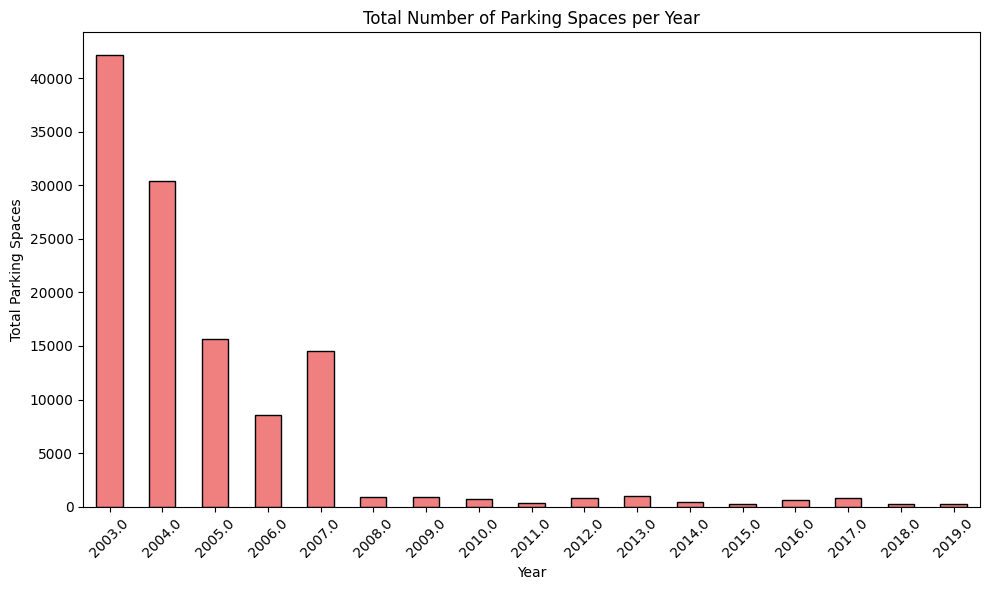

In [188]:
# Convert 'creation_date' to datetime and extract the year.
df_spaces['creation_date'] = pd.to_datetime(df_spaces['creation_date'], errors='coerce')
df_spaces['creation_year'] = df_spaces['creation_date'].dt.year

# Group by the creation year and sum the total number of parking spaces.
spaces_by_year = df_spaces.groupby('creation_year')['num_spaces'].sum().sort_index()

# Plot a bar chart to visualize the total parking spaces per year.
plt.figure(figsize=(10, 6))
spaces_by_year.plot(kind='bar', color='lightcoral', edgecolor='black')
plt.title("Total Number of Parking Spaces per Year")
plt.xlabel("Year")
plt.ylabel("Total Parking Spaces")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Number of rows: 28762
Number of columns: 28
Total Memory Usage (MB): 34.21

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28762 entries, 0 to 28761
Data columns (total 28 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   FID                             28762 non-null  object        
 1   street_code                     28762 non-null  int64         
 2   street_name                     28762 non-null  object        
 3   num_spaces                      28727 non-null  float64       
 4   restriction                     28627 non-null  object        
 5   street_status                   28634 non-null  object        
 6   vejside                         28557 non-null  object        
 7   district                        28758 non-null  object        
 8   parking_order                   19533 non-null  object        
 9   parking_type                    28624 non-null

/opt/anaconda3/envs/my-env/lib/python3.11/site-packages/geopandas/geoseries.py:860: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


Geographic data available. Valid geometries: 28756 out of 28762


<Figure size 800x600 with 0 Axes>

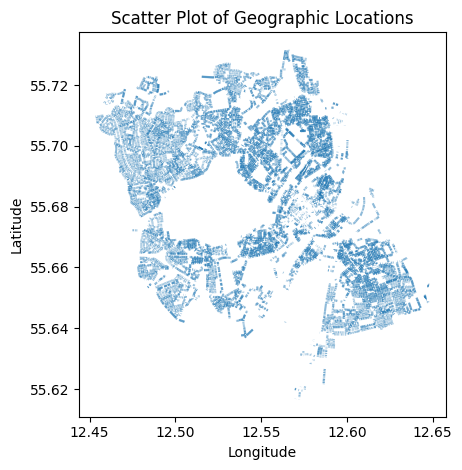

In [189]:
# --- 1. Basic Overview ---
# Basic dimensions and memory usage
print("Number of rows:", df_spaces.shape[0])
print("Number of columns:", df_spaces.shape[1])
memory_mb = df_spaces.memory_usage(deep=True).sum() / (1024 * 1024)
print("Total Memory Usage (MB): {:.2f}".format(memory_mb))

# Print DataFrame info for data types, non-null counts, etc.
print("\nDataFrame Info:")
print(df_spaces.info())

# --- 2. Date Range and Other Properties ---
# Convert date columns to datetime (if present)
date_columns = ["creation_date", "correction_date"]
for col in date_columns:
    if col in df_spaces.columns:
        df_spaces[col] = pd.to_datetime(df_spaces[col], errors='coerce')
        print(f"{col} range: {df_spaces[col].min()} to {df_spaces[col].max()}")

# Check if geographic data is available:
if 'wkb_geometry' in df_spaces.columns:
    try:        
        def load_wkt(geom_str):
            try:
                return wkt.loads(geom_str)
            except Exception as e:
                # Print the problematic value and error message, then return None.
                print("Error parsing geometry:", geom_str, e)
                return None

        # Assuming df_spaces is your DataFrame and the geometry column is named 'wkb_geometry'
        # (even if it contains WKT values)
        df_spaces['geometry'] = df_spaces['wkb_geometry'].apply(lambda x: load_wkt(x) if pd.notnull(x) else None)

        # Create a GeoDataFrame; assuming your coordinate system is WGS84 (EPSG:4326)
        gdf = gpd.GeoDataFrame(df_spaces, geometry='geometry', crs="EPSG:4326")

        print("Geographic data available. Valid geometries:", gdf['geometry'].notnull().sum(), "out of", len(gdf))

        # Quick scatter plot of the locations
        plt.figure(figsize=(8, 6))
        gdf.plot(markersize=1, alpha=0.5)
        plt.title("Scatter Plot of Geographic Locations")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.tight_layout()
        plt.show()
        
    except ImportError:
        print("GeoPandas and/or Shapely is not installed. Install these for geographic plotting.")
    except Exception as e:
        print("An error occurred when plotting geographic data:", e)
else:
    print("No geographic data found (wkb_geometry column not available).")
